In [1]:
%pip install -Uqq fastbook nbdev
from fastbook import *

Note: you may need to restart the kernel to use updated packages.


In [2]:
urls = search_images_ddg('pug', max_images=100) # DuckDuckGo, can search any image
len(urls), urls[0]

(100, 'https://imagepng.org/wp-content/uploads/2017/12/Pug-9.jpg')

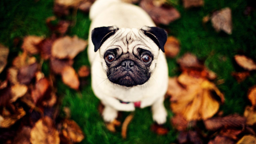

In [3]:
dest = Path('images/pug.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=True)
im = Image.open(dest)
im.thumbnail((256,256))
im

In [21]:
path = Path('images/pug-or-not')

if not path.exists():
    path.mkdir()

searches = [
    'pug',
    'french bulldog',
    'chihuahua',
]

for item in searches:
    if not (path/item).exists():
        print(f"Downloading {item} images")
        dest = (path/item)
        dest.mkdir(parents=True, exist_ok=True)
        results = search_images_ddg(f'{item} dog')
        download_images(dest, urls=results[:200])
        resize_images(dest, max_size=400, dest=dest)

In [22]:
# Remove broken images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink);
len(failed)

15

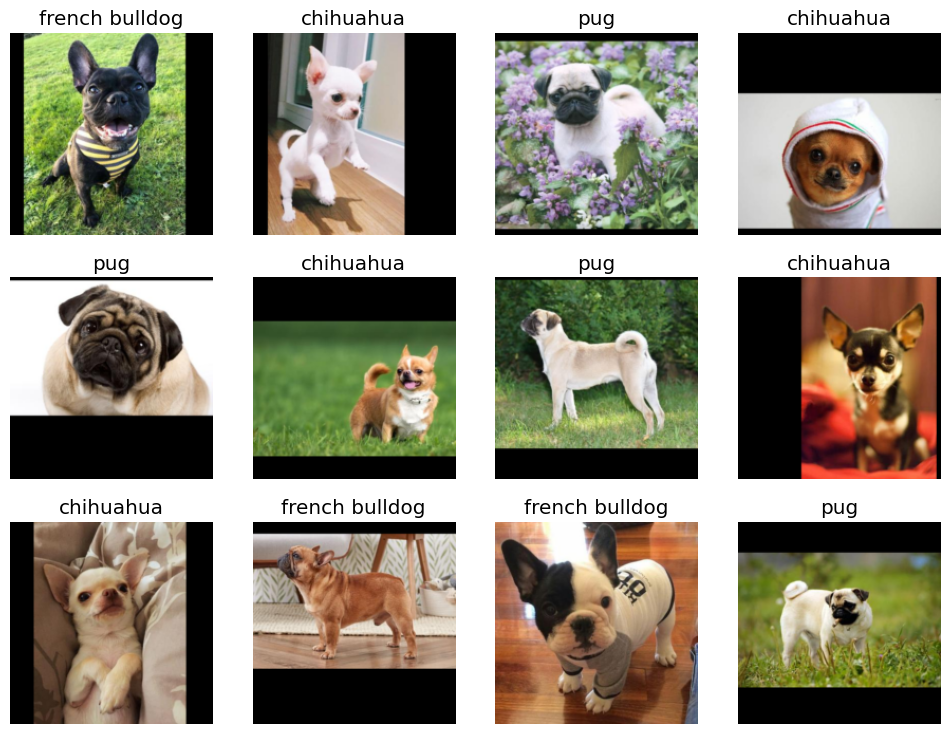

In [23]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # ImageBlock: input, CategoryBlock: output
    get_items=get_image_files, # get images from folder
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # split into train/valid sets (20% validation) and seed for reproducibility
    get_y=parent_label, # get label from parent folder
    item_tfms=[Resize(192, ResizeMethod.Pad, pad_mode='zeros')]
).dataloaders(path)

dls.show_batch(max_n=12, nrows=3)

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.157546,0.135956,0.035714,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.296132,0.081305,0.026786,00:01
1,0.217599,0.086938,0.026786,00:01
2,0.154184,0.119362,0.044643,00:01
3,0.116115,0.076510,0.026786,00:01
4,0.090286,0.076124,0.026786,00:01
5,0.073160,0.073240,0.026786,00:01
6,0.060833,0.074029,0.026786,00:01
7,0.050743,0.068274,0.026786,00:01


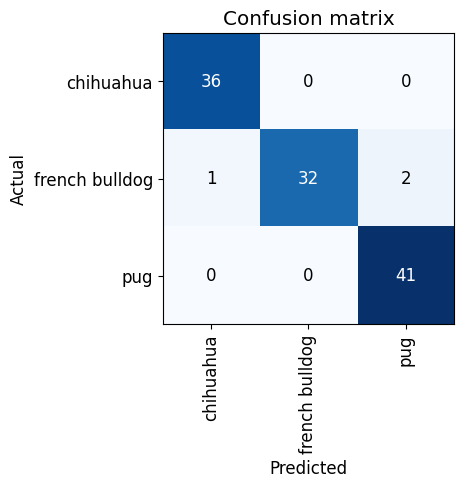

In [26]:
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

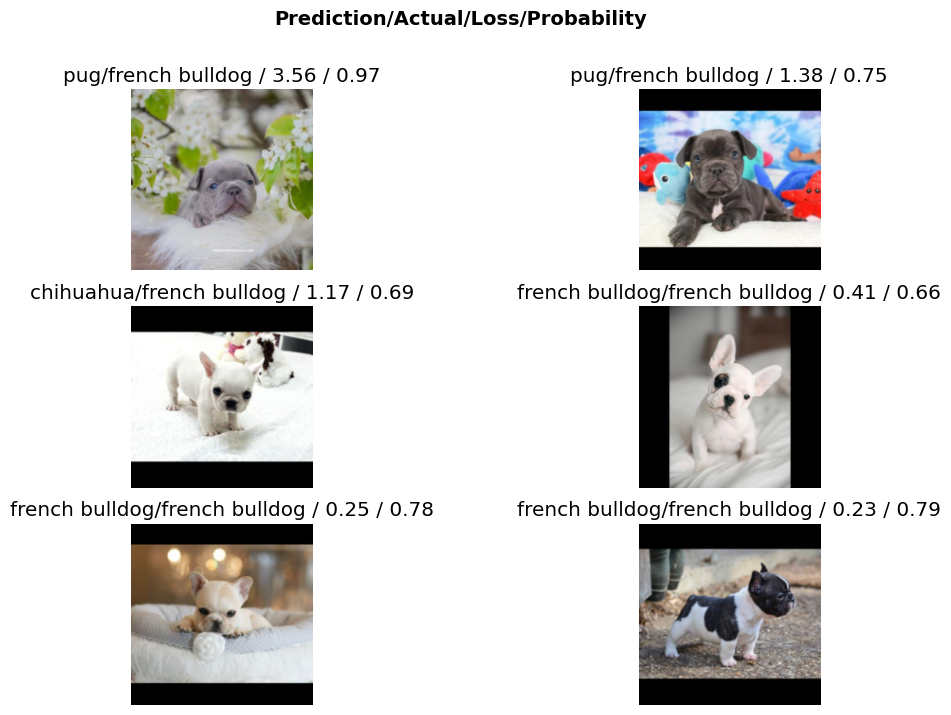

In [31]:
interpretation.plot_top_losses(6, nrows=3, figsize=(12, 8))

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [37]:
deleted_files = []
for idx in cleaner.delete():
    try:
        deleted_files.append(cleaner.fns[idx].unlink())
    except Exception as e:
        print(f"Error deleting {cleaner.fns[idx]}: {e}")
print(f"Deleted {len(deleted_files)} files")

moved_files = []
for idx,cat in cleaner.change():
    moved_files.append(shutil.move(str(cleaner.fns[idx]), path/cat))
print(f"Moved {len(moved_files)} files")

Error deleting images/pug-or-not/pug/ffc49e15-922a-43a1-8851-bc9cf3684733.jpeg: [Errno 2] No such file or directory: 'images/pug-or-not/pug/ffc49e15-922a-43a1-8851-bc9cf3684733.jpeg'
Deleted 0 files
Moved 0 files


In [46]:
searches.sort()
categories = searches
print(categories)

['chihuahua', 'french bulldog', 'pug']


In [58]:
predicted_dog,_,probs = learn.predict(PILImage.create('images/chihuahua.jpg'))


cats_and_probs = {cat: probs[i].item() for i, cat in enumerate(categories)}
print(cats_and_probs)

print(f"This is a: {predicted_dog}.")

dog = 'chihuahua'
print(f"Probability it's a {dog}: {cats_and_probs[dog]:.6f}")

{'chihuahua': 0.9999997615814209, 'french bulldog': 1.2836679275096685e-07, 'pug': 8.728079592401627e-08}
This is a: chihuahua.
Probability it's a chihuahua: 1.000000
